# TWM Praktikum 5
#### Wintersemester 2019/2020 (Prof. Dr. Markus Döhring, Dr. Steffen Schnitzer, Nina Krüger)

%%bash
# NUR bei RosettaHub ändern: Cell>CellType>Code
for K in $(apt-key list | grep expired | cut -d'/' -f2 | cut -d' ' -f1); do sudo apt-key adv --recv-keys --keyserver keys.gnupg.net $K; done
sudo cat > /etc/apt/sources.list << EOF
deb http://archive.ubuntu.com/ubuntu xenial main restricted universe multiverse
deb-src http://archive.ubuntu.com/ubuntu xenial main restricted universe multiverse
deb http://archive.ubuntu.com/ubuntu xenial-updates main restricted universe multiverse
deb-src http://archive.ubuntu.com/ubuntu xenial-updates main restricted universe multiverse
deb http://archive.ubuntu.com/ubuntu xenial-backports main restricted universe multiverse
deb-src http://archive.ubuntu.com/ubuntu xenial-backports main restricted universe multiverse
deb http://archive.ubuntu.com/ubuntu xenial-security main restricted universe multiverse
deb-src http://archive.ubuntu.com/ubuntu xenial-security main restricted universe multiverse
#deb http://archive.ubuntu.com/ubuntu xenial-proposed restricted main universe multiverse
#deb-src http://archive.ubuntu.com/ubuntu xenial-proposed restricted main universe multiverse
deb http://archive.canonical.com/ubuntu xenial partner
deb-src http://archive.canonical.com/ubuntu xenial partner
EOF
sudo apt-get -y install graphviz

In [0]:
import sys
if 1==0: #ändern in 1==1, falls auf RosettaHub ausgeführt
    !{sys.executable} -m pip install --upgrade tensorflow-gpu
    !{sys.executable} -m pip install  nltk
    !{sys.executable} -m pip install  sklearn
    !{sys.executable} -m pip install pydotplus
    !{sys.executable} -m pip install  graphviz
    !{sys.executable} -m pip install  --upgrade keras
    !{sys.executable} -m pip install --upgrade tensorflow

In [0]:
import sys
if 1==0: #ändern in 1==1, falls auf TWM ausgeführt
    !{sys.executable} -m pip install --ignore-installed --upgrade tensorflow-gpu
    !{sys.executable} -m pip install --ignore-installed nltk
    !{sys.executable} -m pip install --ignore-installed sklearn
    !{sys.executable} -m pip install --ignore-installed pydotplus
    !{sys.executable} -m pip install --ignore-installed graphviz
    !{sys.executable} -m pip install --ignore-installed --upgrade keras
    !{sys.executable} -m pip install --ignore-installed --upgrade tensorflow
    !{sys.executable} -m pip uninstall -y numpy
    !{sys.executable} -m pip uninstall -y numpy
    !{sys.executable} -m pip uninstall -y numpy
    !{sys.executable} -m pip install --upgrade numpy

In [0]:
#imports und keras/tensorflow Einstellungen für Reproduzierbarkeit
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)

import keras
keras.__version__
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.externals.six import StringIO  
from IPython.display import Image, display  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from keras.datasets import imdb

import json
import numpy
import nltk

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import imdb
from keras.preprocessing import sequence

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
#wir setzen eine globalen Parameter für die maximale Länge von Reviews.
#Alle Reviews, die länger als review_length Wörter sind, werden vor der Modellbildung entsprechend gekürzt 
review_length = 500

#ein weiterer globaler Parameter gibt an, wie groß das Dictionnary sein darf.
#Es werden grundsätzlich die nwords am häufigsten im Corpus vorkommenden Wörter verwendet. 
nwords = 10000


Hinweis: ein Großteil dieses Notebooks basiert auf dem Buch "Deep Learning with Python" (Chollet 2017), insbesondere Kapitel 6, und entsprechend bereitgestelltem Code: https://github.com/fchollet/deep-learning-with-python-notebooks


## 1. IMDB Movie Reviews - Explorative Datenanalyse

In Praktikum 5 arbeiten wir mit dem IMDB Datensatz, der durch Keras bereitgestellt wird. Dieser enthält insgesamt 50.000 stark positiv/negativ geprägte Reviews. Der folgende Python Code liefert 25.000 Reviews (X\_ Arrays) mit entsprechenden Labels (Y\_ Arrays) für das Training und 25.000 Reviews für das Testen eines Modells. 

In [0]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=nwords)

Die von Keras bereitgestellten Datenstrukturen bestehen aus Arrays von Ganzzahlen, die Einträge in einem Lexikon darstellen. Um uns Texte anschauen (oder ggf. textuell weiterverarbeiten) zu können, müssen wir diese "zurückübersetzen", d.h. die Ganzzahlen wieder in Wörter transformieren. Weiterhin kürzen wir die Reviews auf eine in den globelen Parmetern gesetzte Länge. 

In [0]:
# word_index ist ein dictionnary, das Wörter auf eine Ganzzahl abbildet
word_index = imdb.get_word_index()
# wir kehren den Word Index um und bilden nun Ganzzahlen auf Wörter ab
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Wir dekodieren die Reviews. Achtung: Die Indizes sind um 3 verschoben
# weil 0, 1 and 2 reservierte Indizes für "padding", "start of sequence" und "unknown" sind
X_train = [sequence[0:min(review_length,len(sequence))] for sequence in X_train]
X_test = [sequence[0:min(review_length,len(sequence))] for sequence in X_test]
X_train = [
    ' '.join(
        reverse_word_index.get(i - 3, '?')
        for i in X_train[i]
        if i < len(reverse_word_index)
    ) for i in range(len(X_train))
]

X_test = [
    ' '.join(
        reverse_word_index.get(i - 3, '?')
        for i in X_test[i]
        if i < len(reverse_word_index)
    ) for i in range(len(X_test))
]

### Aufgabe 1: Schauen Sie sich einige Reviews und deren Labels an
Ist ein Datensatz mit 1 gelabelt, dann steht dies fuer einen eher positives Review. Die 0 als Label steht fuer ein eher negatives Review.

In [5]:
print('Training entries: ' + str(len(X_train)) + ', Labels: ' + str(len(y_train)))

for i in range(0, 10, 1):
  print('Label: ' + str(y_train[i]) + ', Entry: ' + str(X_train[i]))

Training entries: 25000, Labels: 25000
Label: 1, Entry: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

### Antwort:   
Die Betrachtung der ersten zehn Review-Texte hat gezeigt, dass die Labels sehr gut für die einzelnen Reviews gewählt wurden.

### Aufgabe 2: Identifizieren Sie die relevantesten Features (Wörter) anhand des Chi²-Wertes

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(X_train)

from sklearn.feature_selection import chi2
chi2_score = chi2(X,y_train)[0]
indices_chi2 = np.argsort(chi2_score)

results = list()
for x in range(1, 10, 1):
  word = vectorizer.get_feature_names()[indices_chi2[-x]]
  results.append(word)
results

['bad',
 'worst',
 'great',
 'awful',
 'waste',
 'terrible',
 'movie',
 'excellent',
 'stupid']

In [7]:
# other solution
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True,stop_words='english')
X = vectorizer.fit_transform(X_train)

from sklearn.feature_selection import chi2
results = vectorizer.get_feature_names()
chi2score = chi2(X,y_train)[0]
words_chi2 = np.argsort(chi2score)

counter = -1
while (counter > -11):
  number = words_chi2[counter]
  print(results[number])
  counter = counter -1

bad
worst
great
awful
waste
terrible
movie
excellent
stupid
worse


### Aufgabe 3: Prüfen und begründen Sie, ob „accuracy“ ein sinnvolles Gütemaß für einen Klassifikator auf diesem Datensatz ist.  

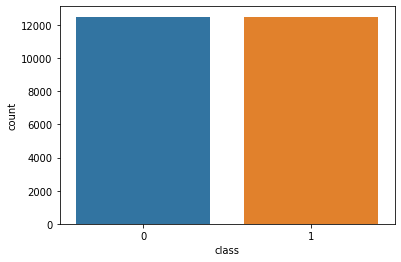

In [8]:
%matplotlib inline
import seaborn as sns
import pandas as pd
unique, counts = numpy.unique(y_train, return_counts=True)
count_labels = pd.DataFrame(zip(unique, counts))
count_labels.columns = ['class', 'count']
sns.barplot(x='class', y='count', data=count_labels)

### Antwort:   
Formel:   
<a target="_blank"><img src="https://latex.codecogs.com/png.latex?\dpi{107}&space;Accuracy&space;=&space;\frac{TP&space;&plus;&space;TN}{TP&plus;FP&plus;FN&plus;TN}" title="Accuracy = \frac{TP + TN}{TP+FP+FN+TN}" /></a>   

Der Plot zeigt, dass die beiden Klassen (0 und 1) die gleiche Anzahl von Review-Texten enthalten. Die Fehlermetrik Accuracy kann vor allem auf balancierten Datensätzen aussagekräftig eingesetzt werden, dies trifft bei diesem Datensatz zu. (Die Trainings- und Testdaten sollten balanciert sein.)

## 2. Deep Learning
### 2.1. RNN mit Embeddings


Im folgenden lernen wir ein RNN mit Embeddings Layer über 10 Iterationen (Epochen). Für jede Epoche wird die Performance (accuracy) für die Trainings- und die Validierungsdaten (20%, die vom ursprünglichen Trainingsdatensatz nochmal beiseite gelegt wurdden) ausgegeben. Am Ende werden die entsprechenden Werte im Zeitverlauf graphisch dargestellt. 

In [0]:
from keras.preprocessing import sequence


print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=nwords)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=review_length)
input_test = sequence.pad_sequences(input_test, maxlen=review_length)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

In [0]:
%%time
from keras.layers import Dense
import keras 
#tbCallBack = keras.callbacks.TensorBoard(log_dir='/home/student/PycharmProjects/test/logs/', histogram_freq=0, write_graph=True, write_images=True)
model = Sequential()
model.add(Embedding(nwords, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2#,
                     #callbacks=[tbCallBack]
                   )            


In [0]:
def plothist(hist):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()


    plt.show()
    

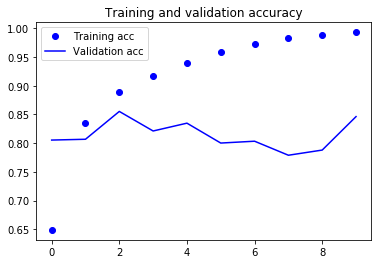

In [12]:
plothist(history)


### Aufgabe 4: Wie interpretieren Sie die Performance-Kurven zum RNN bzw. was fällt Ihnen auf?

### Antwort:
Es ist zu erkennen, dass das RNN auf den Trainingsdaten eine deutlich bessere Performance hat, als auf den Validierungsdaten. Dieses Ergebnis zeigt, dass bei diesem RNN ein Overfitting vorliegen könnte. Die Verteilung der Trainings- und der Validierungsdaten scheint sich zu unterscheiden. Es ist allerdings auch anzumerken, dass das RNN bei höheren Epochen wieder besser auf den Validierungsdaten funktionieren könnte.

Basierend auf der Train-Validation Performance entscheiden wir, unser Modell auf den gesamten Trainingsdaten über 4 Epochen zu trainieren. Dann geben wir die Performance auf den Testdaten aus. 

In [0]:
model.reset_states()

model.fit(input_train, y_train, epochs=2, batch_size=128)
results = model.evaluate(input_test, y_test)
results[1]



### Aufgabe 5: Schauen Sie sich einige der "drastischsten" false positives und false negatives an (hohe Score und Label=0 oder niedrige Score und Label=1). Können Sie erahnen, was das Modell ggf. verwirrt hat?

In [0]:
prediction = model.predict(np.array(input_test[:5000]))

false_neg = 0
false_pos = 0

for row, pred in enumerate(prediction):
    if(y_test[row] == 1 and pred < 0.2 and false_neg < 5):
        print("False Negative: Label={}, Prediction={}, Text:\n{}".format(y_test[row], pred, X_test[row]))
        false_neg += 1

    if(y_test[row] == 0 and pred > 0.7 and false_pos < 5):
        print("False Positive: Label={}, Prediction={}, Text:\n{}".format(y_test[row], pred, X_test[row]))
        false_pos += 1

### Antwort:
Beispiel False Negative:  
"? i was very disappointed when this show was canceled although i can not vote i live on the island of i sat down to see the show on ? and was very surprised that it didn't aired the next day i read on the internet that it was canceled br br it's true not every one was as much talented as the other but there were very talented people singing br br i find it very sad for them br br that they worked so hard and there dreams came ? down br br its a pity br br"

Das gezeigte Review ist ein positives Review, allerdings stuft das RNN es als negatives Review ein. Ein Grund hierfür sind Wörter wie "very disappointed" oder "very sad". 

Beispiel False Positive:   
"? this movie made me think of how i could write something about it without personally ? the director and all the actors who as an australian i am proud of for actually getting out there and making a film br br but the movie itself let me tell you a story br br found this dvd in my local rental shop yesterday and had vague ? of the reviews at the time of cinema release here so i thought i would give it a go br br for some reason i decided to watch the ? ? before i watched the actual movie not something that i usually do turned the ? ? off halfway through as i'd had enough cringing at the ? we so wonderful for putting together such a hard hitting film with such a raw ? attitude br br the movie ugh full of clichés and pathetic character development the actors well done guys you are ? and i applaud you and just like a team is only as good as the coach that directs them you unfortunately did not have a great script to work with br br i felt that the movie actually so many of the subjects that it seemed to want to cover i have seen many reviews here that refer to it as nothing more than a soap agreed br br finally and forgive me if i don't phrase this correctly i was extremely disappointed that there were no optimistic overtones at all yes we all know that life is full of hard stuff and yes we know that things such as incest do occur but i really find it hard to applaud a movie that has not one piece of joy in it i believe that a director has a responsibility to put it in there somewhere otherwise the movie is all about them and their feelings they have created it for themselves not for an audience br br which i think is the basis of why this movie isn't so great the special features mention that the director wrote the screenplay in a ? hour sitting the day after he himself tried to end his own life well it may have been ? for him to do this however the movie ? of self ? when you know the story behind why it was written i feel horrid i'm going to write a movie about feeling horrid note i have read the interview with andrew urban and understand why needed to write something to help him through his own issues but i believe there is a line in film that cannot be crossed the line of making a movie purely for your own emotional needs and i feel that this is what has unintentionally happened here br br by his own admission the director had no technical experience at all and sadly this makes the movie come off looking like nothing more than a year twelve media project"

Das gezeigte Review ist ein negatives Review, allerdings stuft das RNN es als positives Review ein. Ein Grund hierfür sind Wörter wie "proud of" oder "so wonderful".

### 2.2 RNN mit Glove 50 Layer

Nun trainieren wir ein RNN mit der selben Architektur wie vorher, nur dass wir anstelle eines parallel trainierten 32-dimensionalen Embeddings ein 50-dimensionales, vortrainiertes Word-Embedding verwenden.

In [0]:
import os
import numpy as np
from io import BytesIO
from zipfile import ZipFile
import requests

embeddings_index = {}

glove6B = 'glove.6B.50d.txt'

if os.path.isfile(glove6B):
    print('Glove tokens file already exists. No need to download it.')
    f = open(glove6B)
else:
    print('Glove tokens file does not exists. Download can take some time.')
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    resp = requests.get(url)
    zipfile = ZipFile(BytesIO(resp.content))
    f = zipfile.open(glove6B)
    #saving it for the next run
    zipfile.extract(glove6B)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

from keras.datasets import imdb
embedding_dim = 50
word_index = imdb.get_word_index()
embedding_matrix = np.zeros((nwords, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < nwords:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
%%time
model = Sequential()
model.add(Embedding(nwords, 50))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2#,
                     #callbacks=[tbCallBack]
                   )            


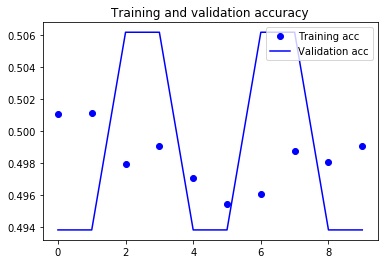

In [17]:
plothist(history)


In [0]:
model.reset_states()
model.fit(input_train, y_train, epochs=3, batch_size=128)
results = model.evaluate(input_test, y_test)
results

### Aufgabe 6: Optional (nur wenn Sie gut in der Zeit liegen und fit in der Materie sind!): Wie interpretieren Sie die Performance-Kurven und Ergebnisse auf den Testdaten zum RNN mit vorgelernten Glove-Embedding bzw. was fällt Ihnen auf

### Antwort:
Die vorgelernten Glove-Embeedings verschlechtern die Performance-Kurven, da die Kantengewichtungen nicht unserem Anwendungsfall entsprechen. Des Weiteren sieht das Modell wie ein Random-Modell aus.

### 2.3 LSTM

Nun trainieren wir anstatt eines Modells mit normalen RNN Zellen ein Modell mit LSTM Zellen. Ansonsten bleiben alle anderen Rahmenbedingungen identisch zum Modell unter 2.1

In [0]:
%%time 
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(nwords, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

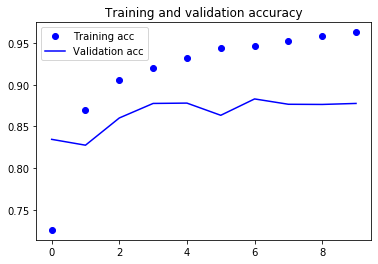

In [20]:
plothist(history)

In [0]:
model.reset_states()
model.fit(input_train, y_train, epochs=4, batch_size=128)
results = model.evaluate(input_test, y_test)
results

### Aufgabe 7: Wie interpretieren Sie die Performance-Kurven und Ergebnisse auf den Testdaten zum LSTM bzw. was fällt Ihnen auf?

### Antwort:   
Ein Long Short Term Memory (LSTM) ist grundsätzlich aufgebaut wie ein Rekurrentes Neuronales Netz (RNN). Zusätzlich wird noch ein extra Memory-Strang mitgeführt, welchem explizit Informationen innerhalb der Zelle entzogen bzw. hinzugefügt werden. Die Accuracy der Trainingsdaten steigt annäherend mit einer Frequenz log(x). Das LSTM ist stabiler als das RNN, da die Accuracy auf den Validierungsdaten deutlich besser ist. 

## 3. Not So Deep Learning

Im folgenden verwenden wir sehr einfache Klassifikationsmodelle: Eine logistische Regression (siehe ggf. Wikipedia o.ä.) und einen Decision Tree aufbauend auf TF-IDF gewichteten Unigrammen+Bigrammen. 

## Logistische Regression

In [22]:
%%time
model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('log', LogisticRegression())
])

model.fit(X_train, y_train)

CPU times: user 31.5 s, sys: 9.76 s, total: 41.2 s
Wall time: 28.8 s


In [23]:
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))
print((y_pred == y_test).mean())

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     12319
           1       0.89      0.88      0.89     12681

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

0.88588


In [24]:
# Ausgabe der Features sortiert nach ihren Koeffizienten innerhalb des LogReg Modells
np.array(model.named_steps['tfidf'].get_feature_names())[np.argsort(model.named_steps['log'].coef_[0])]

array(['bad', 'worst', 'the worst', ..., 'and', 'excellent', 'great'],
      dtype='<U31')

## Decision Tree

In [0]:
%%time
model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('tree', DecisionTreeClassifier(criterion='gini', max_depth=4))
])

model.fit(X_train, y_train)

In [26]:
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))
print((y_pred == y_test).mean())

              precision    recall  f1-score   support

           0       0.48      0.83      0.61      7233
           1       0.90      0.63      0.74     17767

    accuracy                           0.69     25000
   macro avg       0.69      0.73      0.68     25000
weighted avg       0.78      0.69      0.71     25000

0.69124


In [27]:
dot_data = StringIO()

export_graphviz(model.named_steps['tree'], out_file=dot_data, filled=True, rounded=True, special_characters=True)

splitArgs = model.named_steps['tree'].tree_.feature.tolist()

dot_data = dot_data.getvalue()

print('Das sind die Splitargumente des DecisionTrees:')

for x in ([arg for arg in splitArgs if arg != -2 ]):
    rep = model.named_steps['tfidf'].get_feature_names()[x] 
    dot_data = dot_data.replace('X<SUB>'+str(x)+'</SUB>', str(rep))
    print(rep)

Das sind die Splitargumente des DecisionTrees:
bad
worst
waste
awful
city
worst
beautiful
incredible
great
worst
bad
excellent
worst
bad
out


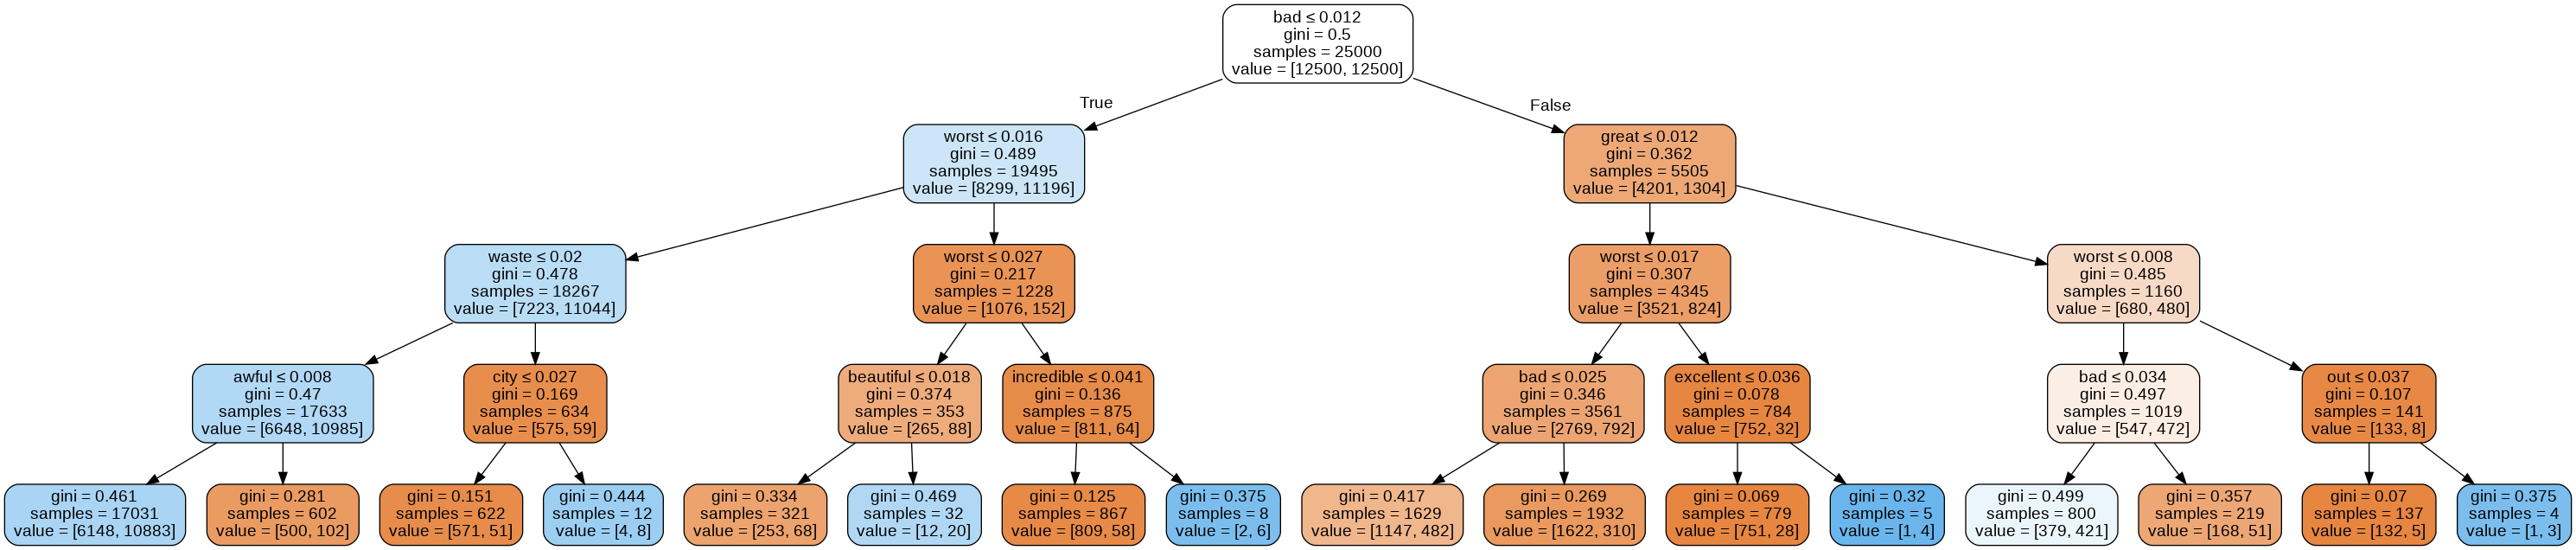

In [28]:
%matplotlib notebook
# Falls Sie https://www.graphviz.org/ installiert haben, koennen Sie den Decision Tree auch plotten
# In der twm VM koennen Sie graphviz mit: sudo apt-get -y install graphviz
# installieren
try:
    graph = pydotplus.graph_from_dot_data(dot_data)
    display(Image(graph.create_png()))
except:
    print('graphviz ist nicht installiert')

### Aufgabe 8: Wie interpretieren Sie die Ergebnisse der "einfacheren" Klassifikationsmodelle auf den Testdaten bzw. was fällt Ihnen auf? Inwiefern deckt sich die Wichtigkeit der Features mit der, die Sie in Aufgabe (2) ermittelt haben?

### Antwort:
Man erkennt, dass die logistische Regression bessere Ergebnisse als der Decision Tree liefert. Die logistische Regression erreicht eine Accuracy von ca. 88,59 %. Hingegen erreicht der Decision Tree nur eine Accuracy von ca. 69,13 %. Die Wichtigkeit der Features decken sich größtenteils mit Aufgabe 2 (Chi2-Test). 